In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

Implement co-ordinate descent algorithms

In [2]:
def soft_threshold(z, lam):
    return np.sign(z) * np.maximum(np.abs(z) - lam, 0.0)


def objective_ls(A, y, x):
    r = y - A.dot(x)
    return 0.5 * np.dot(r, r)


def objective_lasso(A, y, x, alpha):
    return objective_ls(A, y, x) + alpha * np.linalg.norm(x, 1)


def coordinate_descent_ls(A, y, x0=None, max_iter=1000, tol=1e-6, verbose=False):
    n, p = A.shape
    if x0 is None:
        x = np.zeros(p)
    else:
        x = x0.copy()
    # Precompute column norms squared
    col_norm2 = np.sum(A * A, axis=0)
    # Avoid division by zero
    col_norm2[col_norm2 == 0] = 1.0
    r = y - A.dot(x)
    obj_vals = [objective_ls(A, y, x)]
    start = time.time()
    for it in range(max_iter):
        max_delta = 0.0
        # iterate coordinates (cyclic)
        for j in range(p):
            aj = A[:, j]
            # compute coordinate optimal for least squares (closed form)
            rho = aj.dot(r) + col_norm2[j] * x[j]
            x_new = rho / col_norm2[j]
            delta = x_new - x[j]
            if delta != 0.0:
                r -= aj * delta
                x[j] = x_new
                max_delta = max(max_delta, abs(delta))
        obj_vals.append(objective_ls(A, y, x))
        if verbose and (it % 50 == 0 or it == max_iter - 1):
            print(f"iter {it:4d} obj {obj_vals[-1]:.6f} max_delta {max_delta:.3e}")
        if max_delta < tol:
            break
    elapsed = time.time() - start
    return x, np.array(obj_vals), it + 1, elapsed


def coordinate_descent_lasso(A, y, alpha, x0=None, max_iter=1000, tol=1e-6, verbose=False):
    n, p = A.shape
    if x0 is None:
        x = np.zeros(p)
    else:
        x = x0.copy()
    col_norm2 = np.sum(A * A, axis=0)
    col_norm2[col_norm2 == 0] = 1.0
    r = y - A.dot(x)
    obj_vals = [objective_lasso(A, y, x, alpha)]
    start = time.time()
    for it in range(max_iter):
        max_delta = 0.0
        for j in range(p):
            aj = A[:, j]
            rho = aj.dot(r) + col_norm2[j] * x[j]
            # soft-thresholding divided by norm2
            x_new = soft_threshold(rho, alpha) / col_norm2[j]
            delta = x_new - x[j]
            if delta != 0.0:
                r -= aj * delta
                x[j] = x_new
                max_delta = max(max_delta, abs(delta))
        obj_vals.append(objective_lasso(A, y, x, alpha))
        if verbose and (it % 50 == 0 or it == max_iter - 1):
            print(f"iter {it:4d} obj {obj_vals[-1]:.6f} max_delta {max_delta:.3e}")
        if max_delta < tol:
            break
    elapsed = time.time() - start
    return x, np.array(obj_vals), it + 1, elapsed


Apply to examples

In [3]:
def demo_least_squares():
    np.random.seed(0)
    n, p = 200, 50
    A = np.random.randn(n, p)
    x_true = np.zeros(p)
    x_true[:5] = np.array([3.0, -1.5, 2.0, 0.5, -2.2])
    y = A.dot(x_true) + 0.5 * np.random.randn(n)

    x_cd, obj_cd, iters, t = coordinate_descent_ls(A, y, max_iter=5000, tol=1e-8, verbose=False)
    x_ls, _, _, _ = coordinate_descent_ls(A, y, max_iter=1, tol=1e-12)  # quick run starting from zeros (same as normal run)
    # Compare with numpy least squares
    x_np, *_ = np.linalg.lstsq(A, y, rcond=None)

    print("Least squares demo")
    print(f"Coordinate descent iters: {iters} time {t:.4f}s final obj {obj_cd[-1]:.6f}")
    print("First 10 coefficients (true | CD | numpy ls):")
    for i in range(10):
        print(f"{i:2d}: {x_true[i]:6.3f} | {x_cd[i]:6.3f} | {x_np[i]:6.3f}")

    plt.figure(figsize=(9, 3))
    plt.subplot(1, 2, 1)
    plt.plot(obj_cd, label="CD objective")
    plt.yscale("log")
    plt.xlabel("sweep")
    plt.ylabel("objective (log)")
    plt.legend()
    plt.subplot(1, 2, 2)
    idx = np.arange(p)
    plt.plot(idx, x_true, "ko-", label="true")
    plt.plot(idx, x_cd, "rx--", label="cd")
    plt.plot(idx, x_np, "b+:", label="np.linalg")
    plt.legend()
    plt.tight_layout()
    plt.show()


def demo_lasso():
    np.random.seed(1)
    n, p = 200, 100
    A = np.random.randn(n, p)
    x_true = np.zeros(p)
    nonzero = np.random.choice(p, 8, replace=False)
    x_true[nonzero] = np.random.uniform(-3, 3, size=nonzero.size)
    y = A.dot(x_true) + 0.8 * np.random.randn(n)

    alpha = 1.0
    x_cd, obj_cd, iters, t = coordinate_descent_lasso(A, y, alpha, max_iter=5000, tol=1e-6, verbose=False)

    print("\nLasso demo")
    print(f"alpha={alpha} cd iters: {iters} time {t:.4f}s final obj {obj_cd[-1]:.6f}")
    print("Nonzero indices in true:", np.where(x_true != 0)[0])
    print("Nonzero indices found (cd):", np.where(np.abs(x_cd) > 1e-3)[0])

    plt.figure(figsize=(9, 3))
    plt.subplot(1, 2, 1)
    plt.plot(obj_cd, label="CD objective")
    plt.yscale("log")
    plt.xlabel("sweep")
    plt.ylabel("objective (log)")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x_true, "ko-", label="true")
    plt.plot(x_cd, "rx--", label="cd lasso")
    plt.legend()
    plt.tight_layout()
    plt.show()


Illustrate Coordinate Descent

Least squares demo
Coordinate descent iters: 23 time 0.0021s final obj 19.436678
First 10 coefficients (true | CD | numpy ls):
 0:  3.000 |  3.001 |  3.001
 1: -1.500 | -1.461 | -1.461
 2:  2.000 |  1.947 |  1.947
 3:  0.500 |  0.467 |  0.467
 4: -2.200 | -2.197 | -2.197
 5:  0.000 |  0.033 |  0.033
 6:  0.000 | -0.024 | -0.024
 7:  0.000 | -0.015 | -0.015
 8:  0.000 |  0.007 |  0.007
 9:  0.000 | -0.001 | -0.001


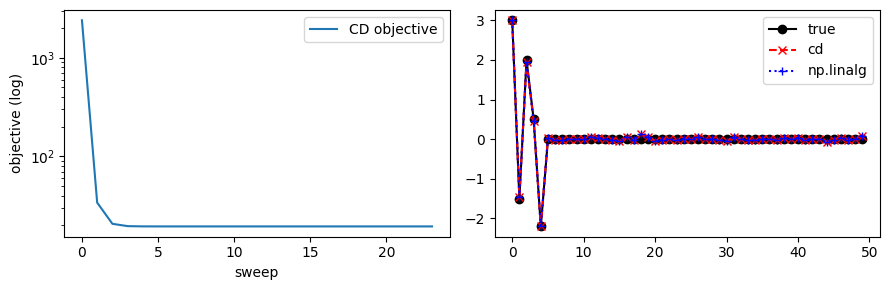

In [4]:
demo_least_squares()


Lasso demo
alpha=1.0 cd iters: 42 time 0.0168s final obj 50.219404
Nonzero indices in true: [10 23 31 43 45 49 61 82]
Nonzero indices found (cd): [ 0  1  2  3  4  5  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 28 29 30 31 32 34 35 36 37 38 39 40 41 42 43 45 46 47 48 49 50 51 52
 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76
 77 78 79 80 82 83 84 85 87 88 89 90 92 93 94 95 96 97 98 99]


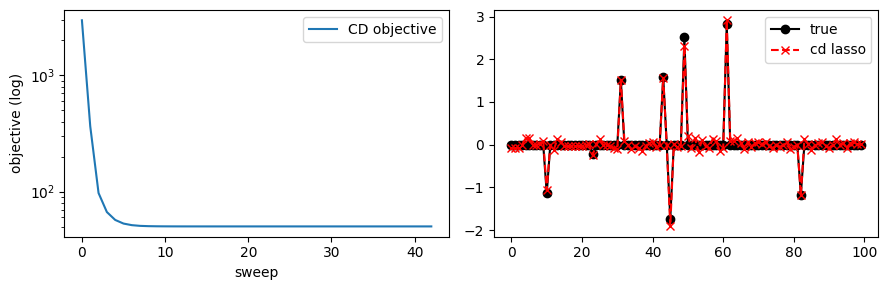

In [5]:
demo_lasso()